In [33]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import nltk,re, string
import matplotlib.pyplot as plt

from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
print(sys.path)

['', '/Users/sasali/anaconda/lib/python35.zip', '/Users/sasali/anaconda/lib/python3.5', '/Users/sasali/anaconda/lib/python3.5/plat-darwin', '/Users/sasali/anaconda/lib/python3.5/lib-dynload', '/Users/sasali/anaconda/lib/python3.5/site-packages', '/Users/sasali/anaconda/lib/python3.5/site-packages/Sphinx-1.5.1-py3.5.egg', '/Users/sasali/anaconda/lib/python3.5/site-packages/aeosa', '/Users/sasali/anaconda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg', '/Users/sasali/anaconda/lib/python3.5/site-packages/Theano-0.9.0rc4-py3.5.egg', '/Users/sasali/scikit-neuralnetwork', '/Users/sasali/anaconda/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '/Users/sasali/anaconda/lib/python3.5/site-packages/IPython/extensions', '/Users/sasali/.ipython']


# Load data

In [5]:
trainv = pd.read_csv('training_variants')
testv = pd.read_csv('test_variants')
trainx = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [6]:
print("Train Variant".ljust(15), trainv.shape)
print("Train Text".ljust(15), trainx.shape)
print("Test Variant".ljust(15), testv.shape)
print("Test Text".ljust(15), testx.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


We have 3321 obs. in training set and 5668 obs. in test set.

In [7]:
trainv.head(2)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2


In [8]:
trainx.head(2)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [9]:
train = pd.merge(trainv, trainx, how='left', on='ID')
test = pd.merge(testv, testx, how='left', on='ID')

# Data Exploration for Variants

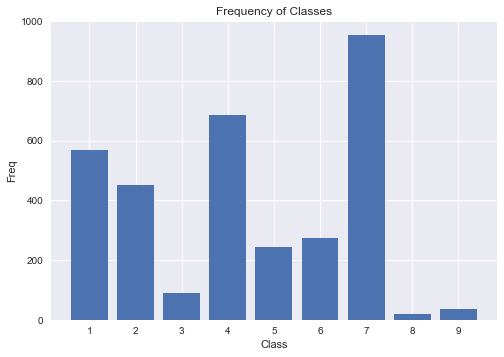

In [10]:
from collections import Counter
ClassDict = Counter(trainv['Class'])
plt.bar(range(len(ClassDict)), ClassDict.values(), align='center')
plt.xticks(range(len(ClassDict)), ClassDict.keys())
plt.title("Frequency of Classes")
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

Imbalanced data distribution.  Most of the mutations belong to Class 1,2,4,7. This may cause a bias in the training process and it may require special attention to improve the ML performance. 

Let us check the distribution of relevant genes.

In [11]:
UniqGene = trainv['Gene'].unique()
print('Num of unique genes: ', len(UniqGene))

Num of unique genes:  264


In [12]:
# How many uniques genes are involved in each mutation class?
GeneDict = {}
VarDict = {}
classList = array(range(9))+1
for i in classList:
    GeneDict[i] = trainv[trainv.Class==i].Gene.nunique()
    VarDict[i] = trainv[trainv.Class==i].Variation.nunique()
print('Gene Dictionary:', GeneDict)
print('Variation Dictionary:', VarDict)

Gene Dictionary: {1: 142, 2: 96, 3: 26, 4: 92, 5: 48, 6: 56, 7: 108, 8: 12, 9: 10}
Variation Dictionary: {1: 423, 2: 399, 3: 89, 4: 669, 5: 242, 6: 265, 7: 889, 8: 19, 9: 37}


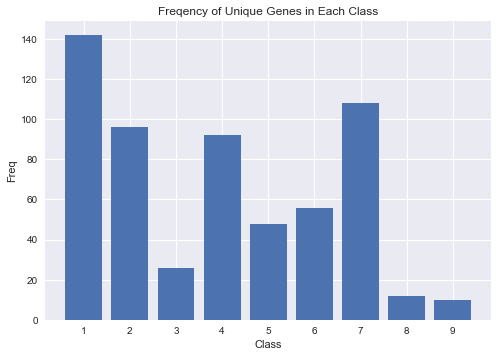

In [13]:
plt.bar(range(len(GeneDict)), GeneDict.values(), align='center')
plt.xticks(range(len(GeneDict)), GeneDict.keys())
plt.title('Freqency of Unique Genes in Each Class')
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

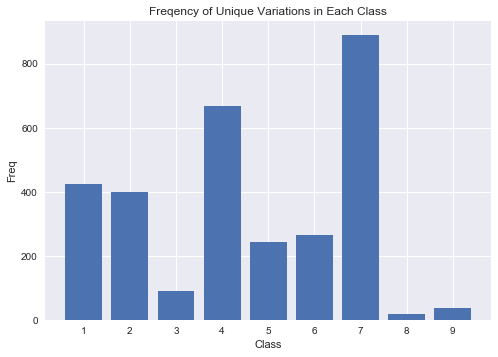

In [14]:
plt.bar(range(len(VarDict)), VarDict.values(), align='center')
plt.xticks(range(len(VarDict)), VarDict.keys())
plt.title('Freqency of Unique Variations in Each Class')
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

# Cleaning text data

import rake
stoppath = "SmartStoplist.txt"
rake_object = rake.Rake("SmartStoplist.txt",3,2,2)
keywords = rake_object.run(text_example)

In [41]:
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('english'))
punct = set(string.punctuation)

In [50]:
def tokenizer(text):
    text = re.sub('[\(\)\{\}<>]', '', text)
    temp = [nltk.stem.snowball.SnowballStemmer("english").stem(word) for word in text.split()]
    # removing stop words, punctuation and digits
    words = [w for w in temp if w not in stop_words and sum(char in punct for char in w)==0 and not str.isdigit(w)]
    return words

In [54]:
X_train = train.loc[:2500, ['Gene','Variation','Text']].values
y_train = train.loc[:2500, 'Class'].values
X_test = train.loc[2500:,  ['Gene','Variation','Text']].values
y_test = train.loc[2500:,  'Class'].values

In [55]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop_words, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
             ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5, verbose=1,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/sasali/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/Users/sasali/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x1007eded0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/sasal.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1007eded0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/sasal.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-03T16:56:47.586730', 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'session': '1E39A584AF754A2C859264C1C8D6CEC1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1E39A584AF754A2C859264C1C8D6CEC1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-03T16:56:47.586730', 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'session': '1E39A584AF754A2C859264C1C8D6CEC1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1E39A584AF754A2C859264C1C8D6CEC1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-03T16:56:47.586730', 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'session': '1E39A584AF754A2C859264C1C8D6CEC1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '342C727C4D1B4C238B21D11D3F62009D', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.grid_search import GridSearchCV\nfro...    n_jobs=-1)\n\ngs_lr_tfidf.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-55-8b3d9240b5d0>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 153dc6710, execution_..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x153df54b0, file "<ipython-input-55-8b3d9240b5d0>", line 25>
        result = <ExecutionResult object at 153dc6710, execution_..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x153df54b0, file "<ipython-input-55-8b3d9240b5d0>", line 25>, result=<ExecutionResult object at 153dc6710, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x153df54b0, file "<ipython-input-55-8b3d9240b5d0>", line 25>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/sasali/Kaggle/medicine/<ipython-input-55-8b3d9240b5d0> in <module>()
     20 gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
     21                            scoring='accuracy',
     22                            cv=5, verbose=1,
     23                            n_jobs=-1)
     24 
---> 25 gs_lr_tfidf.fit(X_train, y_train)
     26 
     27 
     28 
     29 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=1), X=array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object), y=array([1, 2, 2, ..., 5, 3, 5]))
    824         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    825             Target relative to X for classification or regression;
    826             None for unsupervised learning.
    827 
    828         """
--> 829         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...obs', refit=True, scoring='accuracy', verbose=1)>
        X = array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object)
        y = array([1, 2, 2, ..., 5, 3, 5])
        self.param_grid = [{'clf__C': [1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2'], 'vect__ngram_range': [(1, 1)], 'vect__stop_words': [{'a', 'about', 'above', 'after', 'again', 'against', ...}, None], 'vect__tokenizer': [<function tokenizer>]}]
    830 
    831 
    832 class RandomizedSearchCV(BaseSearchCV):
    833     """Randomized search on hyper parameters.

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=1), X=array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object), y=array([1, 2, 2, ..., 5, 3, 5]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    568         )(
    569             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    570                                     train, test, self.verbose, parameters,
    571                                     self.fit_params, return_parameters=True,
    572                                     error_score=self.error_score)
--> 573                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    574                 for train, test in cv)
    575 
    576         # Out is a list of triplet: score, estimator, n_test_samples
    577         n_fits = len(out)

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Mon Jul  3 16:56:49 2017
PID: 3366                   Python 3.5.2: /Users/sasali/anaconda/bin/python
...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('vect', TfidfVectorizer(analyze...0.0001,
          verbose=0, warm_start=False))]), array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object), array([1, 2, 2, ..., 5, 3, 5]), make_scorer(accuracy_score), array([ 130,  131,  132, ..., 2498, 2499, 2500]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...51, 760, 764, 776, 787, 788, 794, 877, 883, 886]), 1, {'clf__C': 1.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': {'a', 'about', 'above', 'after', 'again', 'against', ...}, 'vect__tokenizer': <function tokenizer>}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('vect', TfidfVectorizer(analyze...0.0001,
          verbose=0, warm_start=False))]), array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object), array([1, 2, 2, ..., 5, 3, 5]), make_scorer(accuracy_score), array([ 130,  131,  132, ..., 2498, 2499, 2500]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...51, 760, 764, 776, 787, 788, 794, 877, 883, 886]), 1, {'clf__C': 1.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': {'a', 'about', 'above', 'after', 'again', 'against', ...}, 'vect__tokenizer': <function tokenizer>}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyze...0.0001,
          verbose=0, warm_start=False))]), X=array([['FAM58A', 'Truncating Mutations',
      ...ion with the ENIGMA consortium.']], dtype=object), y=array([1, 2, 2, ..., 5, 3, 5]), scorer=make_scorer(accuracy_score), train=array([ 130,  131,  132, ..., 2498, 2499, 2500]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...51, 760, 764, 776, 787, 788, 794, 877, 883, 886]), verbose=1, parameters={'clf__C': 1.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': {'a', 'about', 'above', 'after', 'again', 'against', ...}, 'vect__tokenizer': <function tokenizer>}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1660 
   1661     try:
   1662         if y_train is None:
   1663             estimator.fit(X_train, **fit_params)
   1664         else:
-> 1665             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(steps=[('....0001,
          verbose=0, warm_start=False))])>
        X_train = array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object)
        y_train = array([9, 9, 9, ..., 5, 3, 5])
        fit_params = {}
   1666 
   1667     except Exception as e:
   1668         if error_score == 'raise':
   1669             raise

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/pipeline.py in fit(self=Pipeline(steps=[('vect', TfidfVectorizer(analyze...0.0001,
          verbose=0, warm_start=False))]), X=array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object), y=array([9, 9, 9, ..., 5, 3, 5]), **fit_params={})
    263         Returns
    264         -------
    265         self : Pipeline
    266             This estimator
    267         """
--> 268         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(steps=[(....0001,
          verbose=0, warm_start=False))])>
        X = array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object)
        y = array([9, 9, 9, ..., 5, 3, 5])
    269         if self._final_estimator is not None:
    270             self._final_estimator.fit(Xt, y, **fit_params)
    271         return self
    272 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(steps=[('vect', TfidfVectorizer(analyze...0.0001,
          verbose=0, warm_start=False))]), X=array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object), y=array([9, 9, 9, ..., 5, 3, 5]), **fit_params={})
    229         Xt = X
    230         for name, transform in self.steps[:-1]:
    231             if transform is None:
    232                 pass
    233             elif hasattr(transform, "fit_transform"):
--> 234                 Xt = transform.fit_transform(Xt, y, **fit_params_steps[name])
        Xt = array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object)
        transform.fit_transform = <bound method TfidfVectorizer.fit_transform of T...3da3bf8>, use_idf=True,
        vocabulary=None)>
        y = array([9, 9, 9, ..., 5, 3, 5])
        fit_params_steps = {'clf': {}, 'vect': {}}
        name = 'vect'
    235             else:
    236                 Xt = transform.fit(Xt, y, **fit_params_steps[name]) \
    237                               .transform(Xt)
    238         if self._final_estimator is None:

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...53da3bf8>, use_idf=True,
        vocabulary=None), raw_documents=array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object), y=array([9, 9, 9, ..., 5, 3, 5]))
   1347         Returns
   1348         -------
   1349         X : sparse matrix, [n_samples, n_features]
   1350             Tf-idf-weighted document-term matrix.
   1351         """
-> 1352         X = super(TfidfVectorizer, self).fit_transform(raw_documents)
        X = undefined
        self.fit_transform = <bound method TfidfVectorizer.fit_transform of T...3da3bf8>, use_idf=True,
        vocabulary=None)>
        raw_documents = array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object)
   1353         self._tfidf.fit(X)
   1354         # X is already a transformed view of raw_documents so
   1355         # we set copy to False
   1356         return self._tfidf.transform(X, copy=False)

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...53da3bf8>, use_idf=True,
        vocabulary=None), raw_documents=array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object), y=None)
    834         max_df = self.max_df
    835         min_df = self.min_df
    836         max_features = self.max_features
    837 
    838         vocabulary, X = self._count_vocab(raw_documents,
--> 839                                           self.fixed_vocabulary_)
        self.fixed_vocabulary_ = False
    840 
    841         if self.binary:
    842             X.data.fill(1)
    843 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in _count_vocab(self=TfidfVectorizer(analyzer='word', binary=False, d...53da3bf8>, use_idf=True,
        vocabulary=None), raw_documents=array([['SF3B1', 'R625L',
        "The RNA matur...ion with the ENIGMA consortium.']], dtype=object), fixed_vocab=False)
    757         indptr = _make_int_array()
    758         values = _make_int_array()
    759         indptr.append(0)
    760         for doc in raw_documents:
    761             feature_counter = {}
--> 762             for feature in analyze(doc):
        feature = undefined
        analyze = <function VectorizerMixin.build_analyzer.<locals>.<lambda>>
        doc = array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object)
    763                 try:
    764                     feature_idx = vocabulary[feature]
    765                     if feature_idx not in feature_counter:
    766                         feature_counter[feature_idx] = 1

...........................................................................
/Users/sasali/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in <lambda>(doc=array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object))
    236         elif self.analyzer == 'word':
    237             stop_words = self.get_stop_words()
    238             tokenize = self.build_tokenizer()
    239 
    240             return lambda doc: self._word_ngrams(
--> 241                 tokenize(preprocess(self.decode(doc))), stop_words)
        doc = array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object)
    242 
    243         else:
    244             raise ValueError('%s is not a valid tokenization scheme/analyzer' %
    245                              self.analyzer)

...........................................................................
/Users/sasali/Kaggle/medicine/<ipython-input-50-06ac61f6e335> in tokenizer(text=array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object))
      1 
----> 2 
      3 
      4 
      5 def tokenizer(text):
      6     text = re.sub('[\(\)\{\}<>]', '', text)
      7     temp = [nltk.stem.snowball.SnowballStemmer("english").stem(word) for word in text.split()]
      8     words = [w for w in temp if w not in stop_words and sum(char in punct for char in w)==0 and not str.isdigit(w)]
      9     return words
     10 

...........................................................................
/Users/sasali/anaconda/lib/python3.5/re.py in sub(pattern=r'[\(\)\{\}<>]', repl='', string=array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object), count=0, flags=0)
    177     non-overlapping occurrences of the pattern in string by the
    178     replacement repl.  repl can be either a string or a callable;
    179     if a string, backslash escapes in it are processed.  If it is
    180     a callable, it's passed the match object and must return
    181     a replacement string to be used."""
--> 182     return _compile(pattern, flags).sub(repl, string, count)
        pattern = r'[\(\)\{\}<>]'
        flags.sub = undefined
        repl = ''
        string = array(['SF3B1', 'R625L',
       "The RNA maturat...ccession number EGAS00001000472."], dtype=object)
        count = 0
    183 
    184 def subn(pattern, repl, string, count=0, flags=0):
    185     """Return a 2-tuple containing (new_string, number).
    186     new_string is the string obtained by replacing the leftmost

TypeError: cannot use a string pattern on a bytes-like object
___________________________________________________________________________